In [212]:
import os
import pandas as pd
import datetime
import requests
from bs4 import BeautifulSoup
import nltk

In [213]:
os.getcwd()

'/Users/ericabonnette/Desktop/Springboard Projects/Sentiment Analysis'

In [214]:
pathcovid = './covidtweet.csv'
pathprecovid= './precovidtweet.csv'
pathlockdown= './shutdown.csv'

covidtweets = pd.read_csv(pathcovid)
precovidtweets = pd.read_csv(pathprecovid)
lockdowntweets = pd.read_csv(pathlockdown)

In [269]:
Tweets = pd.concat([covidtweets, precovidtweets, lockdowntweets], axis=0)

In [270]:
#first let's convert the date columns into datetime to be able to sort them properly.
#Tweets['date'] =  pd.to_datetime(Tweets['date'], format='%d%b%Y:%H:%M:%S.%f')
#Tweets[unix_timestamp] = datetime.datetime.fromtimestamp(int(Tweets[unix_timestamp])).strftime('%Y-%m-%d %H:%M:%S')
fulltime = []
for i in Tweets['unix_timestamp']: 
    zuzu = datetime.datetime.fromtimestamp((int(i)/1000)).strftime('%Y-%m-%d %H:%M:%S')
    fulltime.append(zuzu)

In [271]:
Tweets.unix_timestamp = fulltime

In [272]:
Tweets = Tweets.rename(columns= {'unix_timestamp':"post_datetime"})

In [273]:
Tweets = Tweets.drop(columns = ['date', 'search_url', 'url'], axis=1)

In [274]:
Tweets = Tweets.sort_values(by='post_datetime',ascending=True)

In [275]:
Tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57990 entries, 2543 to 13247
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   handle         57990 non-null  object
 1   name           57989 non-null  object
 2   content        57990 non-null  object
 3   replies        57990 non-null  int64 
 4   retweets       57990 non-null  int64 
 5   favorite       57990 non-null  int64 
 6   post_datetime  57990 non-null  object
 7   hashtags       7258 non-null   object
dtypes: int64(3), object(5)
memory usage: 4.0+ MB


In [276]:
#odd, my dataframe apparently has two tweets from 2017. Not dates I'm looking for though. let's drop those

Tweets['post_datetime'] = pd.to_datetime(Tweets['post_datetime'])
datefilter = '01-01-2019'
Tweets = Tweets[Tweets['post_datetime'] > datefilter]
print(Tweets.head())

              handle           name  \
1498        @cheezit       CHEEZ-IT   
949          @Dis_CT           Bill   
6276  @sophiasgalaxy  Sophiasgalaxy   
3207     @jjonescomm      Jen Jones   
443        @boltyboy   Matthew Holt   

                                                content  replies  retweets  \
1498  Take a look at this new #Snapd thing we did. C...      638       675   
949   @goop @Delta @DeltaAssist why is Delta alignin...        0         0   
6276  Since Boeing and your president don’t care abo...        0         0   
3207  @Delta had two great flights with you today. T...        1         0   
443   @chrissyfarr @Estrellajrios Actually @Delta di...        0         0   

      favorite       post_datetime      hashtags  
1498      8088 2019-02-18 06:05:00         Snapd  
949          2 2019-02-19 18:25:24           NaN  
6276         0 2019-03-14 18:22:33  Boeing737Max  
3207         0 2019-03-14 18:44:08    glutenfree  
443          4 2019-03-14 18:48:32       

In [277]:
Tweets

,handle,name,content,replies,retweets,favorite,post_datetime,hashtags
1498,@cheezit,CHEEZ-IT,Take a look at this new #Snapd thing we did. C...,638,675,8088,2019-02-18 06:05:00,Snapd
949,@Dis_CT,Bill,@goop @Delta @DeltaAssist why is Delta alignin...,0,0,2,2019-02-19 18:25:24,NaN
6276,@sophiasgalaxy,Sophiasgalaxy,Since Boeing and your president don’t care abo...,0,0,0,2019-03-14 18:22:33,Boeing737Max
3207,@jjonescomm,Jen Jones,@Delta had two great flights with you today. T...,1,0,0,2019-03-14 18:44:08,glutenfree
443,@boltyboy,Matthew Holt,@chrissyfarr @Estrellajrios Actually @Delta di...,0,0,4,2019-03-14 18:48:32,NaN
...,...,...,...,...,...,...,...,...
449,@laptoptravel,laptoptravel,@susanseaburg @Delta Southwest Airlines Announ...,0,0,0,2020-10-26 16:31:18,COVID | SWA | Southwest | Delta
12799,@laptoptravel,laptoptravel,@Delta Southwest Airlines Announces It Won’t B...,0,0,0,2020-10-26 16:31:46,FlyDelta | COVID | SWA | Southwest | Delta
9808,@loyaltyrocks,Brian Andrews,@Hotwire just lost a customer for life. Daught...,1,0,0,2020-10-26 16:32:19,COVID
11135,@MusIimHistory,Gerald,@ZarainDC @ABC @Delta Science says a mask make...,0,0,0,2020-10-26 16:48:57,NaN


In [224]:
#let's see how sentiment intensity analyzer works first, to see how cleaning the text will affect its scoring.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment_intensity = []
analyzer = SentimentIntensityAnalyzer()
for sentence in Tweets.content:
    vs = analyzer.polarity_scores(sentence)
    sentiment_intensity.append(vs)
    
#now let's get the average sentiment scores on our un-cleaned text data to get an idea on how vader performs 
from collections import defaultdict
avgDict = defaultdict(list)

for eachdict in sentiment_intensity:
    for sentiment, rating in eachdict.items():
        avgDict[sentiment].append(rating)
averages = {sentiment: sum(ratings) / len(ratings) for sentiment, ratings in avgDict.items()}

print(averages)   

{'neg': 0.06056494447126975, 'neu': 0.7917164240877453, 'pos': 0.1477178554183637, 'compound': 0.22504458508656536}


In [154]:
#ok great now let's clean the data and compare those scores.

In [155]:
# I'll create a dictionary to replace common acronyms and abbreviations with their full words, due to twitter character limit.
CONTRACTION_MAP = {
"ain’t": "is not",
"aren’t": "are not",
"can’t": "cannot",
"can’t’ve": "cannot have",
"could’ve": "could have",
"couldn’t": "could not",
"couldn’t’ve": "could not have",
"didn’t": "did not",
"doesn’t": "does not",
"don’t": "do not",
"hadn’t": "had not",
"hadn’t’ve": "had not have",
"hasn’t": "has not",
"haven’t": "have not",
"he’d": "he would",
"he’d’ve": "he would have",
"he’ll": "he will",
"he’ll’ve": "he he will have",
"he’s": "he is",
"how’d": "how did",
"how’d’y": "how do you",
"how’ll": "how will",
"how’s": "how is",
"I’d": "I would",
"I’d’ve": "I would have",
"I’ll": "I will",
"I’ll’ve": "I will have",
"I’m": "I am",
"I’ve": "I have",
"i’d": "i would",
"i’d've": "i would have",
"i’ll": "i will",
"i’ll’ve": "i will have",
"i’m": "i am",
"i’ve": "i have",
"isn’t": "is not",
"it’d": "it would",
"it’d’ve": "it would have",
"it’ll": "it will",
"it’ll’ve": "it will have",
"it’s": "it is",
"let’s": "let us",
"ma’am": "madam",
"mayn’t": "may not",
"might’ve": "might have",
"mightn’t": "might not",
"mightn’t’ve": "might not have",
"must’ve": "must have",
"mustn’t": "must not",
"mustn’t’ve": "must not have",
"needn’t": "need not",
"needn’t’ve": "need not have",
"oughtn’t": "ought not",
"oughtn’t’ve": "ought not have",
"shan’t": "shall not",
"sha’n’t": "shall not",
"shan’t’ve": "shall not have",
"she’d": "she would",
"she’d’ve": "she would have",
"she’ll": "she will",
"she’ll’ve": "she will have",
"she’s": "she is",
"should’ve": "should have",
"shouldn’t": "should not",
"shouldn’t’ve": "should not have",
"so’ve": "so have",
"that’d": "that would",
"that’d’ve": "that would have",
"that’s": "that is",
"there’d": "there would",
"there’d’ve": "there would have",
"there’s": "there is",
"they’d": "they would",
"they’d’ve": "they would have",
"they’ll": "they will",
"they’ll’ve": "they will have",
"they’re": "they are",
"they’ve": "they have",
"to’ve": "to have",
"wasn’t": "was not",
"we’d": "we would",
"we’d’ve": "we would have",
"we’ll": "we will",
"we’ll’ve": "we will have",
"we’re": "we are",
"we’ve": "we have",
"weren’t": "were not",
"what’ll": "what will",
"what’ll’ve": "what will have",
"what’re": "what are",
"what’s": "what is",
"what’ve": "what have",
"when’s": "when is",
"when’ve": "when have",
"where’d": "where did",
"where’s": "where is",
"where’ve": "where have",
"who’ll": "who will",
"who’ll’ve": "who will have",
"who’s": "who is",
"who’ve": "who have",
"why’s": "why is",
"why’ve": "why have",
"will’ve": "will have",
"won’t": "will not",
"won’t’ve": "will not have",
"would’ve": "would have",
"wouldn’t": "would not",
"wouldn’t’ve": "would not have",
"y’all": "you all",
"y’all'd": "you all would",
"y’all'd've": "you all would have",
"y’all're": "you all are",
"y’all've": "you all have",
"you’d": "you would",
"you’d’ve": "you would have",
"you’ll": "you will",
"you’ll’ve": "you will have",
"you’re": "you are",
"you’ve": "you have",
'DM': 'direct message', 'RT': 'Retweet', 'PRT': 'Please retweet', 'MT': 'Modified tweet', 'CC': 'Carbon-copy', 'CX': 'customer experience', 'EM': 'Email Marketing', 'TBH': 'to be honest', 'WFH': 'work from home', 'SEO': 'Search Engine Optimization', 'SROI': 'Social Return on Investment', 'SN': 'Social Network', 'YT': 'YouTube', 'UGC': 'User Generated Content', 'SMO': 'Social Media Optimization', 'FB': 'Facebook', 'LI': 'LinkedIn', 'SM': 'Social Media', 'SMM': 'Social Media Marketing', 'EZine': 'Electronic Magazine', 'BGD': 'Background', 'CD': 'Code , parents are around', 'BTW': 'By the way', 'ABT': 'About', 'DD': 'Dear daughter', 'AFAIK': 'As far as I know', 'AYFKMWTS': 'Are you fucking kidding me with this', 'BR': 'Best regards', 'CHK': 'Check', 'CULR': 'See you later', 'FML': 'Fuck my life', 'FUBAR': 'Fucked up beyond all repair', 'BBFN': 'Bye for now', 'B4': 'Before', 'FF': 'Follow Friday', 'EMA': 'Email address', 'DYK': 'Did you know', 'FTF': 'Face to face', 'HAGN': 'Have a good night', 'DAM': 'Don’t annoy me', 'FFS': 'For Fucks Sake', 'EML': 'Email', 'FOTD': 'Find of the day', 'FTW': 'For the win', 'FWIW': 'For what it’s worth', 'HTH': 'Hope that helps', 'GMAFB': 'Give me a fucking break', 'ICYMI': 'In case you missed it', 'GTFOOH': 'Get the fuck out of here', 'GTS': 'Guess the song', 'HOTD': 'Headline of the day', 'IIRC': 'If I remember correctly', 'KYSO': 'Knock your socks off', 'KK': 'ok', 'HT': 'Heard through', 'IDK': 'I don’t know', 'IDC': 'I don’t care', 'LHH': 'Laugh hella hard', 'ZOMG': 'OMG to the max', 'IMHO': 'In my humble opinion', 'NFW': 'No fucking way', 'ORLY': 'Oh really', 'YOYO': 'You’re on your own', 'LMAO': 'Laughing my ass off', 'IRL': 'In real life', 'JK': 'Just kidding', 'JV': 'Joint venture', 'LOL': 'Laugh out loud', 'LMK': 'Let me know', 'JSYK': 'Just so you know', 'NSW': 'Not safe work', 'NSFW': 'Not safe for work', 'MRJN': 'Marijuana', 'MIRL': 'Meet in real life', 'NCT': 'Nobody cares, though', 'RLRT': 'Real-life re-tweet', 'NBD': 'no big deal', 'OMFG': 'Oh my fucking God', 'PNP': 'Party and Play', 'QOTD': 'quote of the day', 'RE': 'regarding', 'RTQ': 'Read the question', 'NM': 'not much', 'PPL': 'people', 'SFW': 'Safe for work', 'OOMF': 'One of my friends', 'NTS': 'Note to self', 'RTFM': 'Read the fucking manual', 'SMH': 'Shaking my head', 'STFW': 'Search the fucking web', 'TFTT': 'Thanks for this tweet', 'TFTF': 'Thanks for the follow', 'TY': 'Thank you', 'SRSLY': 'Seriously', 'SRS': 'Serious', 'SMDH': 'Shaking my damn head', 'STFU': 'Shut the fuck up', 'TL': 'Timeline', 'TYIA': 'Thank you in advance', 'TT': 'Trending topic', 'W': 'With', 'W/': 'with', 'TLDR': 'Too long didn’t read', 'TL;DR': 'Too long didn’t read', 'TMB': 'Tweet me back', 'TYVW': 'Thank you very much', 'WTV': 'Whatever', 'YMMV': 'Your mileage may vary', 'YW': 'You’re welcome', 'YKYAT': 'You know you’re addicted to', 'W/E': 'Whatever or weekend', 'TYT': 'Take your time', 'YKWIM': 'You know what I mean', 'YOLO': 'You only live once', 'YGTR': 'You got that right', 'H8': 'hate', 'GR8': 'great', 'HIFW': 'How I feel when', 'FOMO': 'fear of missing out', 'HMU': 'Hit me up', 'IMO': 'in my opinion', 'IKR': 'I know right', '4U': 'For you', 'RU': 'are you', 'adorb': 'adorable', 'adorbs': 'adorable', 'alc': 'alcohol', 'awk': 'awkward', 'awks': 'awkward', 'choreo': 'choreography', 'collab': 'collaboration', 'cray': 'crazy', 'craycray': 'crazy', 'defs': 'definitely', 'delish': 'delicious', 'fams': 'family', 'gorg': 'gorgeous', 'hilar': 'hilarious', 'hilars': 'hilarious', 'jellz': 'jealous', 'liq': 'liquor', 'merch': 'merchandise', 'milli': 'million', 'obvi': 'obvious', 'perf': 'perfect', 'presh': 'precious', 'pregs': 'pregnant', 'probs': 'probably'
}
#fullwords = {k.lower(): v for k, v in fullwords.items()}

In [183]:
#let's clean up the apostrophes so we have consistent formatting throughout.
clean_text = []
for sentence in Tweets.content:
    new = sentence.replace(r"'", r"’")
    clean_text.append(new)
print(clean_text[0:10])

['Take a look at this new #Snapd thing we did. Closer. Closer. No, closer. Lick the screen. Wait, what. https://t.co/QHvSLCD9BK', '@goop @Delta @DeltaAssist why is Delta aligning with pseudo science?', 'Since Boeing and your president don’t care about your safety, I suggest that if you fly you make sure you are not on a #Boeing737Max. Every flight lists the airplane on that route. I suggest you do your research and avoid that plane. I’m going to. BTW @Delta doesn’t fly them.', '@Delta had two great flights with you today. The #glutenfree snack mix was such a treat! Please keep this item for your most appreciative gf customers. Flight attendant from Minneapolis to Kansas City was incredibly nice. Good articles on gender parity too in Sky.', '@chrissyfarr @Estrellajrios Actually @Delta did this in the 90s. Note how health care costs have plummeted in the meanwhile', '@_theAustinBrown @Delta Hard to figure, especially if a seat was open. Makes no sense. Pray for safe travels for all!', 'A

In [184]:
#now let's lengthen any abbreviations and contractions.
clean_text2 = []
for sentence in clean_text:
  for word in sentence.split():
    if word in CONTRACTION_MAP: 
      sentence = sentence.replace(word, CONTRACTION_MAP[word])
  clean_text2.append(sentence)
print(clean_text2[0:10])

['Take a look at this new #Snapd thing we did. Closer. Closer. No, closer. Lick the screen. Wait, what. https://t.co/QHvSLCD9BK', '@goop @Delta @DeltaAssist why is Delta aligning with pseudo science?', 'Since Boeing and your president do not care about your safety, I suggest that if you fly you make sure you are not on a #Boeing737Max. Every flight lists the airplane on that route. I suggest you do your research and avoid that plane. I am going to. By the way @Delta does not fly them.', '@Delta had two great flights with you today. The #glutenfree snack mix was such a treat! Please keep this item for your most appreciative gf customers. Flight attendant from Minneapolis to Kansas City was incredibly nice. Good articles on gender parity too in Sky.', '@chrissyfarr @Estrellajrios Actually @Delta did this in the 90s. Note how health care costs have plummeted in the meanwhile', '@_theAustinBrown @Delta Hard to figure, especially if a seat was open. Makes no sense. Pray for safe travels for

In [185]:

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment_intensity = []
analyzer = SentimentIntensityAnalyzer()
for sentence in clean_text2:
    vs = analyzer.polarity_scores(sentence)
    sentiment_intensity.append(vs)
    avgDict = defaultdict(list)

for eachdict in sentiment_intensity:
    for sentiment, rating in eachdict.items():
        avgDict[sentiment].append(rating)
averagesfullwords  = {sentiment: sum(ratings) / len(ratings) for sentiment, ratings in avgDict.items()}

print(averagesfullwords)
#did that change the sentiment? not really... 

{'neg': 0.06048251362350772, 'neu': 0.7941644650617379, 'pos': 0.14535245223149665, 'compound': 0.21986427364281963}


In [186]:
#let's try replacing all of the stopwords in the text to unclutter the data.
from nltk.corpus import stopwords
stopcorpus = stopwords.words('english')
#ok looks like I need to reformat this to have the same apostrophe as the text
stopwords = []
for sentence in stopcorpus:
    new = sentence.replace(r"'", r"’")
    stopwords.append(new)

import typing
def remove_words(text_data:str,list_of_words_to_remove: typing.List):
    # Remove all words as specified in a custom list of words
    for item in text_data:
        return [item for item in text_data if item not in list_of_words_to_remove]

Tweets['cleaned_text'] = clean_text2
Tweets['cleaned_text']= Tweets['cleaned_text'].astype(str).apply(lambda x: remove_words(x.split(),stopwords))


In [160]:
Tweets['cleaned_text']

1498     [Take, look, new, #Snapd, thing, did., Closer....
949      [@goop, @Delta, @DeltaAssist, Delta, aligning,...
6276     [Since, Boeing, president, care, safety,, I, s...
3207     [@Delta, two, great, flights, today., The, #gl...
443      [@chrissyfarr, @Estrellajrios, Actually, @Delt...
                               ...                        
449      [@susanseaburg, @Delta, Southwest, Airlines, A...
12799    [@Delta, Southwest, Airlines, Announces, It, W...
9808     [@Hotwire, lost, customer, life., Daughter, ex...
11135    [@ZarainDC, @ABC, @Delta, Science, says, mask,...
13247    [@DMVBlackLives, @Delta, Wow., Over, hat., He,...
Name: cleaned_text, Length: 57988, dtype: object

In [187]:
sentiment_intensity = []
analyzer = SentimentIntensityAnalyzer()
for sentence in Tweets['cleaned_text']:
    vs = analyzer.polarity_scores(sentence)
    sentiment_intensity.append(vs)
    
avgDict = defaultdict(list)

for eachdict in sentiment_intensity:
    for sentiment, rating in eachdict.items():
        avgDict[sentiment].append(rating)
averagesforstop  = {sentiment: sum(ratings) / len(ratings) for sentiment, ratings in avgDict.items()}

print(averagesforstop)
#well that changed the sentiment in a really bad way. Everything is suddenly completely neutral 
#and therefore possibly unusable? I'll save this for a wordcloud or something else later then. 

{'neg': 0.002887373249637858, 'neu': 0.9881655514934099, 'pos': 0.008947144236738666, 'compound': 0.006985453887011123}


In [162]:
#Let's get rid of the mentions, URLS, stopwords and maybe even hashes
lower_text = [i.lower() for i in clean_text2]
print(lower_text[0:3])

['take a look at this new #snapd thing we did. closer. closer. no, closer. lick the screen. wait, what. https://t.co/qhvslcd9bk', '@goop @delta @deltaassist why is delta aligning with pseudo science?', 'since boeing and your president do not care about your safety, i suggest that if you fly you make sure you are not on a #boeing737max. every flight lists the airplane on that route. i suggest you do your research and avoid that plane. i am going to. by the way @delta does not fly them.']


In [163]:
#trial = re.sub(^http \s$, '', new)
#^ as a character that designates starts with and $ as shows the end and \s as a space
#regex= re.compile(r"http[s]*" % re.escape(string.punctuation))
import re
nourl= [] 
for i in clean_text2:
    new_token = re.sub(r"http\S+" , "", i)
    if not new_token == u'':
        nourl.append(new_token)

nomentions= [] 
for i in nourl:
    new_token = re.sub(r"@\S+" , "", i)
    if not new_token == u'':
        nomentions.append(new_token)

notags= [] 
for i in nomentions:
    new_token = re.sub(r"#\S+" , "", i)
    if not new_token == u'':
        notags.append(new_token)

In [164]:
#did it change now?
sentiment_intensity_cleaned = []
analyzer = SentimentIntensityAnalyzer()
for sentence in notags:
    vs = analyzer.polarity_scores(sentence)
    sentiment_intensity_cleaned.append(vs)
    

nextavgDict = defaultdict(list)

for eachdict in sentiment_intensity_cleaned:
    for sentiment, rating in eachdict.items():
        nextavgDict[sentiment].append(rating)
clean_averages = {sentiment: sum(ratings) / len(ratings) for sentiment, ratings in nextavgDict.items()}

print(averages, clean_averages)

{'neg': 0.06056494447126975, 'neu': 0.7917164240877453, 'pos': 0.1477178554183637, 'compound': 0.22504458508656536} {'neg': 0.06772252320645976, 'neu': 0.7605966734531898, 'pos': 0.16203537044066557, 'compound': 0.2075005176162026}


In [165]:
#hm. so it looks like cleaning the data to get rid of symbols and punctuation does change the sentiment by a small 
#amount, and specifically it made positive sentiment go up away from neutral, more than changing negative. 
# it seems most likely that getting rid of the punctuation may have contributed to the algorithm seeing URLs 
#(which might be considered neutral) and lessening that. I wonder if there is more sentiment in the hashtags- let's look

In [280]:
#get sentiment for each individual Tweet and append into a column
sentiment_intensity_each = []
analyzer = SentimentIntensityAnalyzer()
for sentence in Tweets.content:
    vs = analyzer.polarity_scores(sentence)
    sentiment_intensity_each.append(vs)
Tweets['sentiment_score'] = sentiment_intensity_each

In [281]:
#create a column on just dates so i can filter sentiment by date of post.
by_day = Tweets['post_datetime'].to_list()
datetimevers = []
for x in by_day:
    datetimevers.append(x.to_pydatetime())
just_date =[]
for x in datetimevers:
    just_date.append(x.strftime('%m/%d/%Y'))
Tweets['date_only'] = just_date

In [282]:
#compound score is the most indicative as a general score, so let's add just a column of those scores only.
scores = Tweets['sentiment_score'].to_list()
compound_scores = [x['compound'] for x in scores]   
Tweets['compound'] = compound_scores

Text(0, 0.5, 'score')

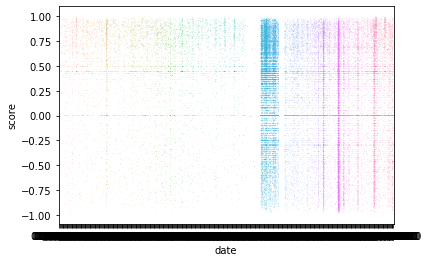

In [259]:
#good. now I want to graph the scores just to get another visualization.
import seaborn as sns
import matplotlib.pyplot as plt
sns.stripplot(x = 'date_only', y = 'compound', data = Tweets, size=.4, jitter=True)
plt.xlabel('date')
plt.ylabel('score')
#although this graph is hard to read because it is plotting thousands of tweets,
#what is clear is that there is a date perdiod (teal blue color) that has A LOT more tweets than the others. 
#The sheer volume of tweets in some is enough to make the entire plot section of that day look like a line.
#there are a few other days, like those in purple etc. 

In [301]:
#let's try grouping by week intervals to make it a little easier to read.
# but, in order to create these weekly intervals, I need to average out the  scores.
Tweets['Datetime'] = pd.to_datetime(Tweets['post_datetime'])
Tweets = Tweets.set_index('Datetime')
weeks = pd.Int64Index(Tweets.index.isocalendar().week)
weekly_avg= Tweets.groupby(weeks).compound.mean()

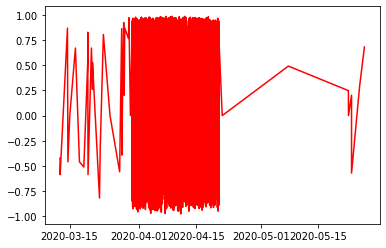

In [327]:
#let's get a visual representation of sentiment scores for a given time: Tweets['2020-08-01']
#what does it look like for the whole dataframe from pre covid vs. post covid? does it trend up or down at all?
overall = Tweets['compound']
fig = plt.plot(overall['2020-03-01': '2020-06-01'], color= 'red', label= 'sentiment score')
plt.show()

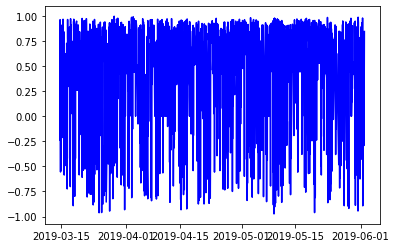

In [329]:
plt.plot(overall['2019-03-01': '2019-06-01'], color= 'blue', label= 'sentiment score')
plt.show()

In [314]:
#Ok so it looks like the earliest date I have is August 03. Now let's try to break this up into chunks of 
#weekly, two week intervals and monthly intervals.

AllAug= Tweets['2020-08-01': '2020-08-31']
AllSept= Tweets['2020-09-01': '2020-09-30']
AllOct= Tweets['2020-10-02': '2020-10-31']
covid_lockdown = Tweets['2020-03-10' : '2020-04-30']

In [318]:
covSent = []
analyzer = SentimentIntensityAnalyzer()
for sentence in covid_lockdown.content:
    vs = analyzer.polarity_scores(sentence)
    covSent.append(vs)
    
avgDict = defaultdict(list)

for eachdict in covSent:
    for sentiment, rating in eachdict.items():
        avgDict[sentiment].append(rating)
covid_lockdownAvg = {sentiment: sum(ratings) / len(ratings) for sentiment, ratings in avgDict.items()}
print(covid_lockdownAvg)

{'neg': 0.0444183329588855, 'neu': 0.8111610424623684, 'pos': 0.14442206245787417, 'compound': 0.25652199056392366}


In [317]:
AugSent = []
analyzer = SentimentIntensityAnalyzer()
for sentence in AllAug.content:
    vs = analyzer.polarity_scores(sentence)
    AugSent.append(vs)
    
avgDict = defaultdict(list)

for eachdict in AugSent:
    for sentiment, rating in eachdict.items():
        avgDict[sentiment].append(rating)
AugAvgSent = {sentiment: sum(ratings) / len(ratings) for sentiment, ratings in avgDict.items()}

print(AugAvgSent)

{'neg': 0.08598154895728348, 'neu': 0.7953327389720084, 'pos': 0.11868664237537788, 'compound': 0.07582142026513676}


In [168]:
OctSent = []
analyzer = SentimentIntensityAnalyzer()
for sentence in AllOct.content:
    vs = analyzer.polarity_scores(sentence)
    OctSent.append(vs)
    
avgDict = defaultdict(list)

for eachdict in OctSent:
    for sentiment, rating in eachdict.items():
        avgDict[sentiment].append(rating)
OctAvgSent = {sentiment: sum(ratings) / len(ratings) for sentiment, ratings in avgDict.items()}

print(OctAvgSent)

{'neg': 0.07046914002393559, 'neu': 0.7882889382800474, 'pos': 0.14123781843050132, 'compound': 0.17026955035048702}


In [169]:
SepSent = []
analyzer = SentimentIntensityAnalyzer()
for sentence in AllSept.content:
    vs = analyzer.polarity_scores(sentence)
    SepSent.append(vs)
    
avgDict = defaultdict(list)

for eachdict in SepSent:
    for sentiment, rating in eachdict.items():
        avgDict[sentiment].append(rating)
SepAvgSent = {sentiment: sum(ratings) / len(ratings) for sentiment, ratings in avgDict.items()}

print(SepAvgSent)

{'neg': 0.06598257735055563, 'neu': 0.7991141483929091, 'pos': 0.13490477620907185, 'compound': 0.20376326224091287}
